In [0]:
%matplotlib inline

!pip install -q tensorflow-gpu==2.0.0-alpha0

import numpy as np
import matplotlib.pyplot as plt
from math import *

from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import glob

from IPython import display
import time

     |████████████████████████████████| 332.1MB 45kB/s 
     |████████████████████████████████| 3.0MB 42.0MB/s 
     |████████████████████████████████| 61kB 27.2MB/s 
     |████████████████████████████████| 419kB 53.3MB/s 


In [0]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.models import Sequential

In [0]:
def sphere_proj(x):
  xn = K.sqrt(1e-4 + K.sum(x**2,axis=3,keepdims=True))
  
  return x / xn

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(64,64,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(Conv2D(256, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(3, 1, activation='linear', padding='same'))
model.add(Activation(sphere_proj))

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, decay=0.02)

In [0]:
filelist = np.array(glob.glob("/gdrive/My Drive/terrain_dataset/*.jpg"))

np.random.seed(12345)
idx = np.random.permutation(filelist.shape[0])
filelist = filelist[idx]

files_train = filelist[0:70]
files_test = filelist[70:]

ims_train = np.array([ (np.array(Image.open(fn))-128.0)/128.0 for fn in files_train ])
ims_test = np.array([ (np.array(Image.open(fn))-128.0)/128.0 for fn in files_test ])

In [0]:
# Assemble batch
def getEasyBatch(files, BS=30):
  x1s = []
  x2s = []
  x3s = []
  for j in range(BS):
    k = np.random.randint(len(files))
    im = files[k]
    
    pos1x = np.random.randint(im.shape[0]-64)
    pos1y = np.random.randint(im.shape[1]-64)
    pos2x = np.random.randint(im.shape[0]-64)
    pos2y = np.random.randint(im.shape[1]-64)
      
    x1s.append(im[pos1x:pos1x+64, pos1y:pos1y+64])
    x2s.append(im[pos2x:pos2x+64, pos2y:pos2y+64])
    
    k = np.random.randint(len(files))
    im = files[k]
    
    pos3x = np.random.randint(im.shape[0]-64)
    pos3y = np.random.randint(im.shape[1]-64)
      
    x3s.append(im[pos3x:pos3x+64, pos3y:pos3y+64])
    
  x1s = np.array(x1s).astype(np.float32)
  x2s = np.array(x2s).astype(np.float32)
  x3s = np.array(x3s).astype(np.float32)
  
  return x1s, x2s, x3s

def getHardBatch(files, BS=30):
  x1s = []
  x2s = []
  x3s = []
  for j in range(BS):
    k = np.random.randint(len(files))
    im = files[k]
    
    stop = False
    while not stop:
      pos1x = np.random.randint(im.shape[0]-64)
      pos1y = np.random.randint(im.shape[1]-64)
      pos2x = np.random.randint(im.shape[0]-64)
      pos2y = np.random.randint(im.shape[1]-64)
      
      r = sqrt((pos1x-pos2x)**2 + (pos1y-pos2y)**2)
      if r<64:
        stop = True
    x1s.append(im[pos1x:pos1x+64, pos1y:pos1y+64])
    x2s.append(im[pos2x:pos2x+64, pos2y:pos2y+64])
    
    stop = False
    while not stop:
      pos3x = np.random.randint(im.shape[0]-64)
      pos3y = np.random.randint(im.shape[1]-64)
      
      r = sqrt((pos1x-pos3x)**2 + (pos1y-pos3y)**2)
      if r>256:
        stop = True
    x3s.append(im[pos3x:pos3x+64, pos3y:pos3y+64])
    
  x1s = np.array(x1s).astype(np.float32)
  x2s = np.array(x2s).astype(np.float32)
  x3s = np.array(x3s).astype(np.float32)
  
  return x1s, x2s, x3s

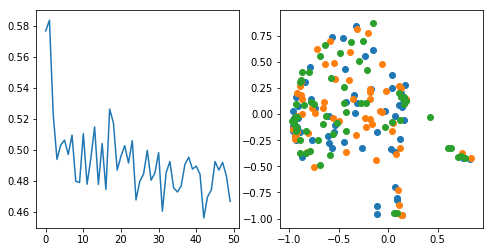

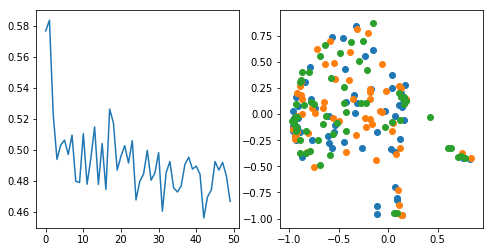

In [0]:
BS = 60
errs = []

for i in range(50):
  for j in range(30):  
    x1s, x2s, x3s = getEasyBatch(ims_train, BS)

    with tf.GradientTape() as tape:
      p1 = model(x1s)
      p2 = model(x2s)
      p3 = model(x3s)

      d1 = K.sqrt(1e-4+K.sum( (p1-p2)**2, axis = 3))
      d2 = K.sqrt(1e-4+K.sum( (p1-p3)**2, axis = 3))
      loss = K.mean(K.maximum(d1-d2 + 1.0, 0))
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  
  sub_err = []
  for j in range(30):
    x1s, x2s, x3s = getEasyBatch(ims_test, BS)

    p1 = model(x1s)
    p2 = model(x2s)
    p3 = model(x3s)

    d1 = K.sqrt(K.sum( (p1-p2)**2, axis = 3))
    d2 = K.sqrt(K.sum( (p1-p3)**2, axis = 3))
    loss = K.mean(K.maximum(d1-d2 + 1.0, 0))
    sub_err.append(K.eval(loss))
  
  errs.append(np.mean(sub_err))
  
  plt.clf()
  plt.subplot(1,2,1)
  plt.plot(errs)
  
  p1 = K.eval(p1).mean(axis=(1,2))
  p2 = K.eval(p2).mean(axis=(1,2))
  p3 = K.eval(p3).mean(axis=(1,2))
  
  plt.subplot(1,2,2)
  plt.scatter(p1[:,0],p1[:,1])
  plt.scatter(p2[:,0],p2[:,1])
  plt.scatter(p3[:,0],p3[:,1])
  
  plt.gcf().set_size_inches((8,4))
  display.clear_output(wait=True)
  display.display(plt.gcf())
  time.sleep(0.01)

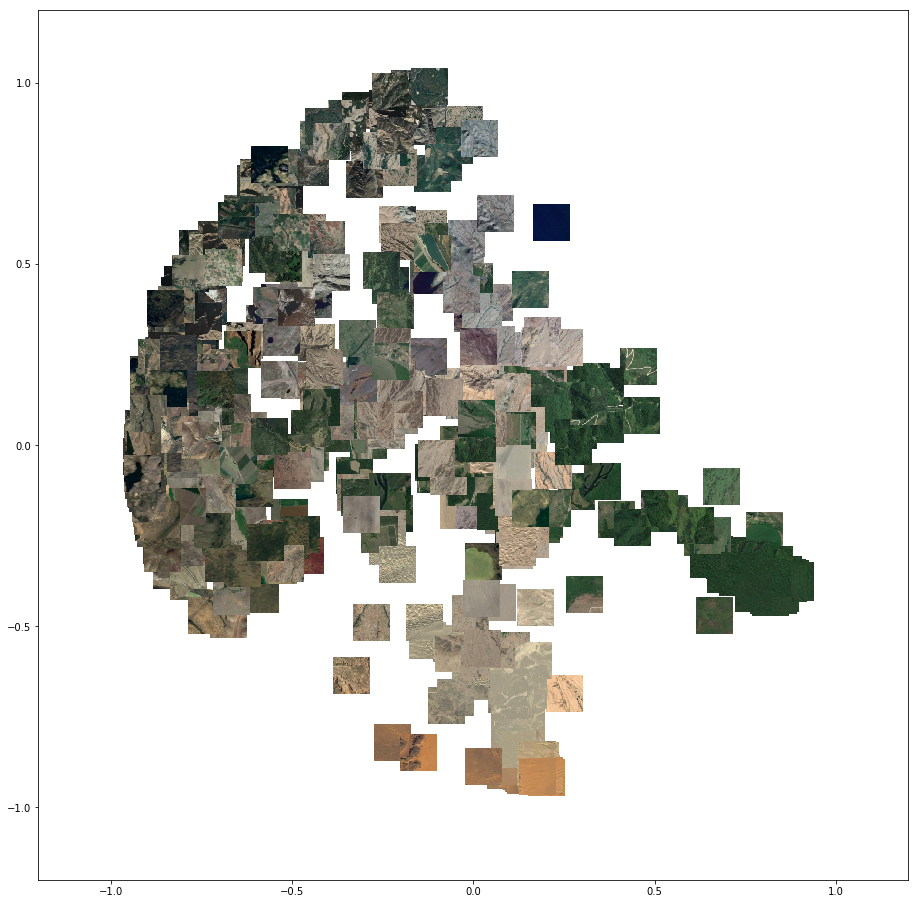

In [0]:
for j in range(5):
  x1s, x2s, x3s = getHardBatch(ims_test, BS)
  p1 = K.eval(model(x1s)).mean(axis=(1,2))
  p3 = K.eval(model(x3s)).mean(axis=(1,2))
  
  for i in range(x1s.shape[0]):
    px = p1[i,0]
    py = p1[i,1]

    plt.imshow(x1s[i]*0.5+0.5, extent=[px,px+0.1,py,py+0.1])

    px = p3[i,0]
    py = p3[i,1]

    plt.imshow(x3s[i]*0.5+0.5, extent=[px,px+0.1,py,py+0.1])
  
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.gcf().set_size_inches((16,16))
plt.show()

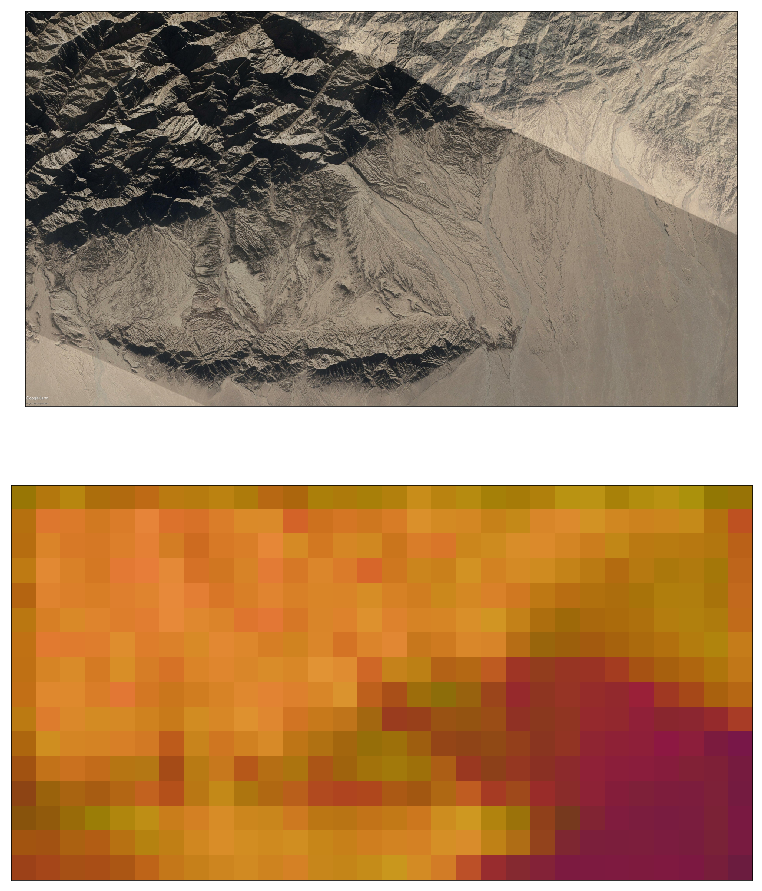

In [0]:
idx = 42
p1_im = K.eval(model(ims_test[idx:idx+1].astype(np.float32)))

plt.subplot(2,1,1)
plt.imshow(0.5 + 0.5*ims_test[idx])
plt.xticks([])
plt.yticks([])

plt.subplot(2,1,2)
plt.imshow(0.5 + 0.5*p1_im[0])
plt.xticks([])
plt.yticks([])

plt.gcf().set_size_inches((16,16))
plt.show()